# Code 2: Policy Gradient: REINFORCE Algorithm

In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

REINFORCE 算法是典型的从交互中学习，因为其优化的目标（即策略期望回报）正是最终所使用策略的性能，这比基于价值的强化学习算法的优化目标（一般是时序差分误差的最小化）要更加直接。 REINFORCE 算法理论上是能保证**局部最优**的，它实际上是借助蒙特卡洛方法采样轨迹来估计动作价值，这种做法的一大优点是可以得到**无偏梯度**。但是，正是因为使用了蒙特卡洛方法，REINFORCE 算法的梯度估计的**方差很大**，可能会造成一定程度上的不稳定。

The REINFORCE algorithm is a typical example of learning from interaction, as its optimization target—the expected return of the policy—directly represents the performance of the policy being used (on-policy). This is more straightforward than the optimization objectives of value-based reinforcement learning algorithms, which generally aim to minimize the temporal difference error. Theoretically, the REINFORCE algorithm can guarantee **local optimality**, as it relies on Monte Carlo methods to sample trajectories and estimate action values. Thus, a significant advantage of this approach is that it yields **unbiased gradients**. However, precisely because it employs Monte Carlo methods, the variance of the gradient estimation in the REINFORCE algorithm is **quite high**, which can potentially lead to a degree of instability.

REINFORCE 算法的具体流程如下：

<img src="./image/pg_alg.png" style="zoom:60%" />

首先定义策略网络PolicyNet，其输入是某个状态，输出则是该状态下的动作概率分布，这里采用在离散动作空间上的softmax()函数来实现一个可学习的多项分布（multinomial distribution）。

First, we define the policy network, PolicyNet, which takes a state as input and outputs the action probability distribution for that state. Here, a learnable multinomial distribution is implemented using the softmax() function on a discrete action space.

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [3]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):  # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor([state_list[i]],
                                 dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 梯度下降

In [4]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0) # gym version 0.21.0
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,
                  device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset() # gym version 0.21.0
            # state, _ = env.reset(seed=0,)   # gym version 0.26.2
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)  # gym version 0.21.0
                # next_state, reward, done, _, _ = env.step(action)   # gym version 0.26.2
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)   # 记录一整局游戏的数据，然后才更新
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

# 3m 18.3s

Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_5293/4125764203.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402374358/work/torch/csrc/utils/tensor_new.cpp:245.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 100/100 [00:09<00:00, 10.47it/s, episode=1000, return=167.400]


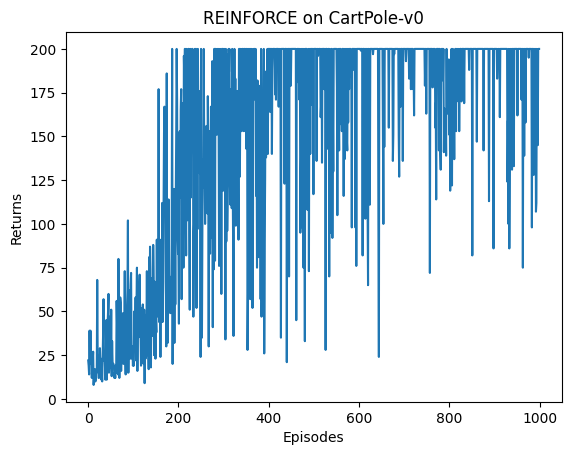

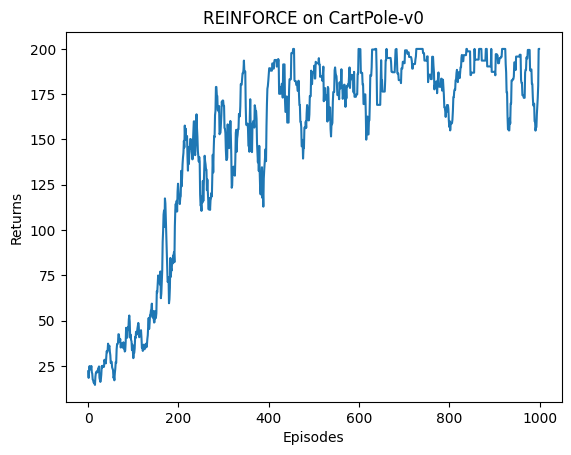

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

相比于前面的 DQN 算法，REINFORCE 算法使用了更多的序列，这是因为 REINFORCE 算法是一个**在线策略**(on-policy)算法，之前收集到的轨迹数据不会被再次利用。此外，REINFORCE 算法的性能也有一定程度的波动，这主要是因为每条采样轨迹的回报值波动比较大，这也是 REINFORCE 算法主要的不足。

Compared to the previous DQN algorithm, the REINFORCE algorithm utilizes a larger number of sequences because it is an **on-policy** algorithm, meaning that previously collected trajectory data is not reused. Additionally, the performance of the REINFORCE algorithm experiences some degree of fluctuation, primarily due to the large variance in the return values of each sampled trajectory, which is a major drawback of the REINFORCE algorithm.